In [231]:
import numpy as np
from batchflow.opensets import MNIST
from batchflow import dataset, B, V, R, P, Pipeline
from batch import MyBatch
import matplotlib.pyplot as plt
import importlib
from batchflow.models.torch import ResNet18
from torch.nn import CrossEntropyLoss
from sklearn.utils.extmath import softmax

In [ ]:
dataset = MNIST(batch_class=MyBatch)

In [242]:
augmentation = (Pipeline()
                .resize((66,66))
                .rotate(angle=P(R('uniform', -35, 35)))
                .scale(factor=P(R('uniform', 0.6, 1.4)), preserve_shape=True, origin='center')
                .invert(p=0.5)
                .custom_noise())

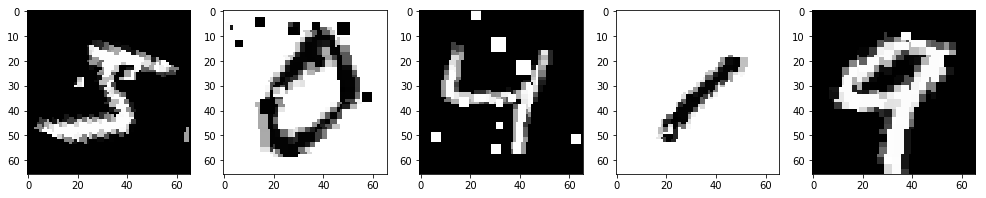

In [245]:
augm = augmentation << dataset.train
batch = augm.next_batch(5)
fig, ax = plt.subplots(1, 5, figsize=(17, 17)) 
for i, axis in enumerate(ax):
    axis.imshow(batch.images[i])

In [184]:
config = {
    'inputs': dict(images={'shape': (66, 66, 1)},
                  labels={'classes': 10,
                         'transform': 'ohe'}),
    'initial_block/inputs': 'images',
    'loss': CrossEntropyLoss,
    'optimiser': 'Adam'
 }

In [185]:
train_pipeline = (Pipeline()
                    .to_array(dtype='float32')
                    .labels_to_long()
                    .init_model('dynamic', ResNet18, 'my_model', config)
                    .init_variable('loss', init_on_each_run=list)
                    .train_model('my_model', B('images'), B('labels'),
                                fetches='loss', save_to=V('loss'), mode='a'))

In [186]:
train = (augmentation + train_pipeline) << dataset.train
train.run(64, n_epochs=1)

In [192]:
loss = train.get_variable('loss')
plt.plot(loss)

In [ ]:
test_pipeline = (Pipeline()
                 .import_model('my_model', train)
                 .to_array('float32')
                 .labels_to_long()
                 .init_variable('metrics', init_on_each_run=None)
                 .init_variable('predictions', init_on_each_run=list)
                 .predict_model('my_model', B('images'), B('labels'),
                               fetches='predictions', save_to=V('predictions'))
                 .gather_metrics('class', targets=B('labels'), fmt='logits',
                                 axis=1, predictions=V('predictions'), 
                                 save_to=V('metrics'), mode='a'))

In [ ]:
test = (augmentation + test_pipeline) << dataset.test
test.run(64)

In [203]:
metrics = test.get_variable('metrics')
metrics.evaluate('accuracy')

0.8441480891719745

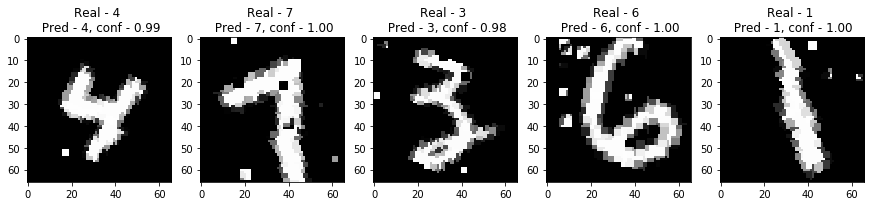

In [248]:
batch = test.next_batch(5)

fig, ax = plt.subplots(1, 5, figsize=(15,15))
pred_logit = test.get_variable('predictions')
iterator = zip(ax, pred_logit, batch.labels, batch.images)
for axis, pred, label, image in iterator:
    image = Image.fromarray(np.squeeze(image))
    axis.imshow(image)
    p = softmax([pred])
    label_pred = np.argmax(p)
    axis.set_title('Real - {} \n Pred - {}, conf - {:.2f}'.format(label,
                                                                   np.argmax(p), p.max()))